# Illustration of HRP 

## Methodology

## Imports 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../')

In [4]:
from typing import List
import datetime
import tqdm
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import yfinance as yf


In [5]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
from opm.hrp.ingest import fetch_historical_data_from_yfinance
from opm.hrp.cluster import HierarchicalClustering
from opm.hrp.recursive_bisection import * 
from opm.hrp.quasi_diagonalization import *
from opm.hrp.utils import *

## Data loading 

In [7]:
start = datetime.datetime(2010,1,1)
end = datetime.date.today()

In [8]:
etf_names = ['AGG', 'BNDX', 'EMB', 'IEFA', 'IEMG', 'ITOT', 'IWN', 'IWS', 
             'JPST', 'MUB', 'SCHV', 'TFI', 'VBR', 'VEA', 'VOE', 'VTI', 'VTIP', 
             'VTV', 'VWO']

In [9]:
etf_historical_data = fetch_historical_data_from_yfinance(security_names = etf_names,
                                                          start_date = start,
                                                          end_date = end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
etf_historical_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Security,Date
64527,44.029999,44.080002,43.799999,43.860001,43.860001,12952900,VWO,2024-07-01
64528,43.790001,44.040001,43.750000,44.020000,44.020000,8358400,VWO,2024-07-02
64529,44.240002,44.680000,44.240002,44.669998,44.669998,7496300,VWO,2024-07-03
64530,44.669998,44.700001,44.369999,44.660000,44.660000,7304400,VWO,2024-07-05
64531,44.700001,44.799999,44.610001,44.660000,44.660000,8686800,VWO,2024-07-08


In [11]:
etf_historical_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Security,Date
64527,44.029999,44.080002,43.799999,43.860001,43.860001,12952900,VWO,2024-07-01
64528,43.790001,44.040001,43.750000,44.020000,44.020000,8358400,VWO,2024-07-02
64529,44.240002,44.680000,44.240002,44.669998,44.669998,7496300,VWO,2024-07-03
64530,44.669998,44.700001,44.369999,44.660000,44.660000,7304400,VWO,2024-07-05
64531,44.700001,44.799999,44.610001,44.660000,44.660000,8686800,VWO,2024-07-08


## EDA 

In [12]:
etf_historical_data['Date'] = pd.to_datetime(etf_historical_data['Date']).dt.date

In [13]:
etf_historical_data.sort_values(by = 'Date', ascending=True, inplace = True)

In [14]:
etf_historical_data['prior_1D_return'] = etf_historical_data.groupby('Security')['Adj Close'].pct_change()

In [15]:
prior_1D_returns = etf_historical_data.pivot_table(index='Date', columns = 'Security', values = 'prior_1D_return')

In [16]:
prior_1D_returns

Security,AGG,BNDX,EMB,IEFA,IEMG,ITOT,IWN,IWS,JPST,MUB,SCHV,TFI,VBR,VEA,VOE,VTI,VTIP,VTV,VWO
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0.004549,NaN,0.006082,NaN,NaN,0.003140,-0.003693,0.008258,NaN,0.001068,0.004298,0.002654,-0.001081,0.000569,0.003109,0.003839,NaN,0.003296,0.003302
2010-01-06,-0.000578,NaN,0.001366,NaN,NaN,0.001370,-0.002022,0.003699,NaN,-0.001456,0.003113,0.001323,0.001623,0.000285,0.007086,0.001390,NaN,0.003284,0.006112
2010-01-07,-0.001157,NaN,-0.005161,NaN,NaN,0.003517,0.011818,0.007107,NaN,0.001167,0.005430,0.000441,0.008821,-0.001991,0.007256,0.004166,NaN,0.005525,-0.008645
2010-01-08,0.000579,NaN,0.001174,NaN,NaN,0.003699,0.005506,0.004705,NaN,0.000194,-0.000772,0.000440,0.003569,0.010832,0.003274,0.003284,NaN,0.001018,0.006128
2010-01-11,-0.000773,NaN,0.007626,NaN,NaN,0.000776,-0.005642,0.000780,NaN,0.000000,0.005019,0.000440,-0.000534,0.006204,0.000870,0.001378,NaN,0.004269,0.001406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,-0.005363,-0.003232,-0.003961,0.001377,0.002055,0.001431,-0.008995,-0.010022,-0.000100,-0.001505,-0.004995,-0.000767,-0.010684,0.000809,-0.009373,0.002019,-0.000748,-0.004114,0.002285
2024-07-02,0.003325,0.002065,0.004900,0.002475,0.002796,0.006221,0.003909,0.003346,0.000597,0.002827,0.003663,0.001974,0.005316,0.002224,0.003221,0.005783,0.000624,0.003756,0.003648
2024-07-03,0.005385,0.002885,0.007825,0.011794,0.013757,0.002924,-0.000396,0.001001,0.000398,0.002631,0.000270,0.002845,0.000275,0.011902,-0.000067,0.004117,0.000832,0.000748,0.014766


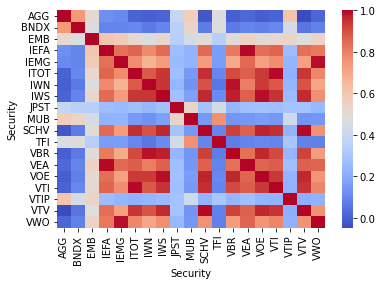

In [17]:
corr = prior_1D_returns.corr()
#Vislualization purposes
ax = sns.heatmap(corr, cmap="coolwarm")

## Hierarchical Clustering 

In [18]:
hierarchical_clustering_model = HierarchicalClustering(is_similarity_matrix=True)

In [19]:
hierarchical_clustering_model.fit(corr)

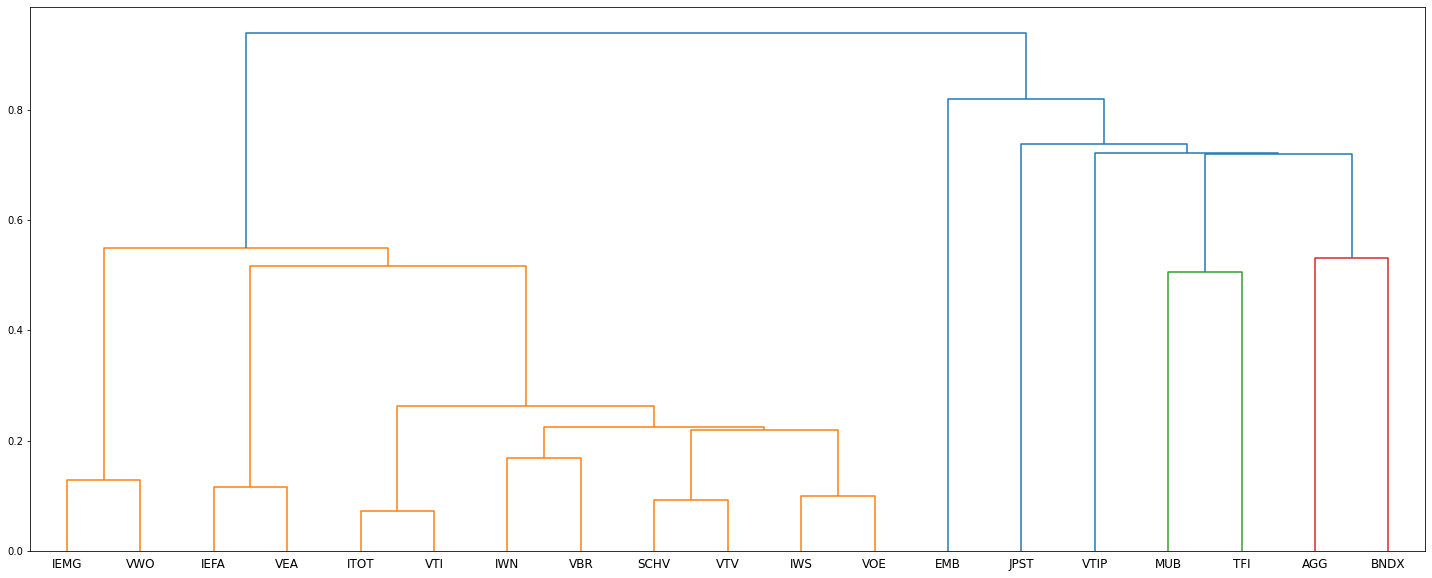

In [20]:
hierarchical_clustering_model.plot_dendrogram()

In [21]:
link = hierarchical_clustering_model.linkage_matrix


## Quasi-diagonalization 

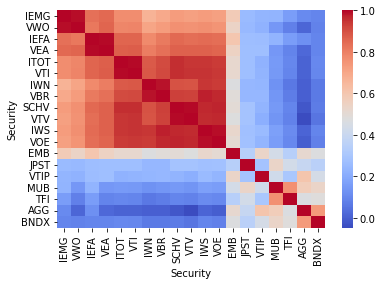

In [22]:
sort_ix = quasi_diagonalize_linkage(link)
etf_names = np.array(etf_names)
df_vis = prior_1D_returns[etf_names[sort_ix]]
corr2 = df_vis.corr()
ax = sns.heatmap(corr2, cmap="coolwarm")

## Recursive bi-section

In [23]:
cluster_items =  [[3, 6, 0, 9, 2, 4, 13, 5, 12, 8, 10, 7, 1, 11]]

In [24]:
while len(cluster_items) > 0:
    # bisection
    """
    Example of bisection: 
    [[3, 6, 0, 9, 2, 4, 13], [5, 12, 8, 10, 7, 1, 11]]
    [[3, 6, 0], [9, 2, 4, 13], [5, 12, 8], [10, 7, 1, 11]]
    [[3], [6, 0], [9, 2], [4, 13], [5], [12, 8], [10, 7], [1, 11]]
    [[6], [0], [9], [2], [4], [13], [12], [8], [10], [7], [1], [11]]
    """
    print(cluster_items)
    cluster_items = [i[int(j):int(k)] for i in cluster_items for j, k in
               ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]

[[3, 6, 0, 9, 2, 4, 13, 5, 12, 8, 10, 7, 1, 11]]
[[3, 6, 0, 9, 2, 4, 13], [5, 12, 8, 10, 7, 1, 11]]
[[3, 6, 0], [9, 2, 4, 13], [5, 12, 8], [10, 7, 1, 11]]
[[3], [6, 0], [9, 2], [4, 13], [5], [12, 8], [10, 7], [1, 11]]
[[6], [0], [9], [2], [4], [13], [12], [8], [10], [7], [1], [11]]


In [25]:
weights_HRP = compute_recursive_bisection_weights(corr, sort_ix)
new_index = [prior_1D_returns.columns[i] for i in weights_HRP.index]
weights_HRP.index = new_index
weights_HRP.name = "HRP"

In [26]:
weights_HRP

IEMG    0.042641
VWO     0.042641
IEFA    0.042558
VEA     0.042558
ITOT    0.040598
VTI     0.040598
IWN     0.041524
VBR     0.021537
SCHV    0.021537
VTV     0.060847
IWS     0.060847
VOE     0.082178
EMB     0.061154
JPST    0.061154
VTIP    0.084044
MUB     0.084044
TFI     0.078737
AGG     0.045402
BNDX    0.045402
Name: HRP, dtype: float64